In [205]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps
import pymc as pm

%matplotlib inline

sns.set()

print ('!!! NOTE! - REMEMBER TO RUN covid_confirmed.ipynb first to produce up-2-date .pkl !!!')

!!! NOTE! - REMEMBER TO RUN covid_confirmed.ipynb first to produce up-2-date .pkl !!!


In [206]:
with open ('country_data.pkl','rb') as f:
    country_dict = pickle.load(f)
    

### set A to the country you want to analyze ###
A = 'Sweden'
###

# not used
B = 'Sweden'
C = 'Spain'
D = 'US'
D = 'Taiwan*'

country_a = country_dict[A]
country_b = country_dict[B]
country_c = country_dict[C]
country_d = country_dict[D]

In [207]:
world_countries = pd.read_csv('world_pop.csv',sep=';',
                     encoding='ISO-8859-1',header=None,
                     names=['population'],
                    thousands=',')
world_countries.index = world_countries.index.str.strip()
pop_df = world_countries

In [208]:
def compute_ppm(country,name):
    country['confirmed_per_M'] = (1e6 * country['confirmed'] / pop_df.loc[name,'population'])
    return country

country_a = compute_ppm(country_a,A)
country_b = compute_ppm(country_b,B)
country_c = compute_ppm(country_c,C)
country_d = compute_ppm(country_d,D)

country_a['ppm_factor'] = country_a['confirmed_per_M'] / country_a['confirmed_per_M'].shift()
country_a['ppm_factor'].replace(np.inf,np.nan,inplace=True)
country_a

,confirmed,factor,inc,deceased,dead_factor,dead_inc,pct_dead,conf_over_dead,dead_conf_ratio,confirmed_per_M,ppm_factor
2020-01-24,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
2020-01-25,0,NaN,0.0,0,NaN,0.0,NaN,NaN,NaN,0.000000,NaN
2020-01-26,0,NaN,0.0,0,NaN,0.0,NaN,NaN,NaN,0.000000,NaN
2020-01-27,0,NaN,0.0,0,NaN,0.0,NaN,NaN,NaN,0.000000,NaN
2020-01-28,0,NaN,0.0,0,NaN,0.0,NaN,NaN,NaN,0.000000,NaN
2020-01-29,0,NaN,0.0,0,NaN,0.0,NaN,NaN,NaN,0.000000,NaN
2020-01-30,0,NaN,0.0,0,NaN,0.0,NaN,NaN,NaN,0.000000,NaN
2020-01-31,1,NaN,1.0,0,NaN,0.0,0.000000,NaN,NaN,0.099017,NaN
2020-02-01,1,1.000000,0.0,0,NaN,0.0,0.000000,NaN,NaN,0.099017,1.000000
2020-02-02,1,1.000000,0.0,0,NaN,0.0,0.000000,NaN,NaN,0.099017,1.000000


In [209]:





limit = 1

# define a common starting point in the day that nr confirmed_per_million is >= 1

def cut_under_limit(df,l):
    return (df.loc[df['confirmed_per_M'] >= limit]).copy()

country_a = cut_under_limit(country_a,limit).reset_index()
country_b = cut_under_limit(country_b,limit).reset_index()
country_c = cut_under_limit(country_c,limit).reset_index()
country_d = cut_under_limit(country_d,limit).reset_index()

country_a['per_M_factor'] = country_a['confirmed_per_M'] / country_a['confirmed_per_M'].shift()
country_b['per_M_factor'] = country_b['confirmed_per_M'] / country_b['confirmed_per_M'].shift()
country_c['per_M_factor'] = country_c['confirmed_per_M'] / country_c['confirmed_per_M'].shift()
country_d['per_M_factor'] = country_d['confirmed_per_M'] / country_d['confirmed_per_M'].shift()


country_a.rename(columns={'index' : 'date'},inplace=True)
country_b.rename(columns={'index' : 'date'},inplace=True)
country_c.rename(columns={'index' : 'date'},inplace=True)
country_d.rename(columns={'index' : 'date'},inplace=True)



In [210]:
### FILTER OUT DAYS ###
#country_a = country_a[-8:]
###


In [211]:
alpha_mu = 0.5
alpha_sigma = 1
beta_mu = 1
beta_sigma = 1

alpha = pm.Normal('alpha',mu=alpha_mu, tau=1/alpha_sigma ** 2)
beta = pm.Normal('beta',mu=beta_mu, tau=1/beta_sigma ** 2)
sigma = pm.Uniform('sigma',lower=0,upper=1)

X = np.linspace(0,max([country_a.index.max(),country_b.index.max(),
                       country_c.index.max(),country_d.index.max()]),100)

def standardize(x):
    return (x - x.mean()) / x.std()

def regression(x,y,alpha,beta,sigma):
    
    @pm.deterministic()
    def linreg_mu(x=x,alpha=alpha,beta=beta):
        return x * beta + alpha

    obs = pm.Normal('obs',mu=linreg_mu,tau = 1 / sigma ** 2,observed=True,value=y)
    
    model = pm.Model([alpha,beta,sigma,linreg_mu,obs])
    map_ = pm.MAP(model)
    map_.fit()

    mcmc = pm.MCMC(model)
    mcmc.sample(10000,5000,2)

    alpha_post = mcmc.trace('alpha')[:]
    beta_post = mcmc.trace('beta')[:]
    sigma_post = mcmc.trace('sigma')[:]
    linreg_mu_post = mcmc.trace('linreg_mu')[:,0]
    
    result = pd.DataFrame({'alpha_post':alpha_post,
                           'beta_post':beta_post,
                           'sigma_post':sigma_post,
                           'linreg_mu_post':linreg_mu_post})

    return result

    

In [212]:
result = regression(country_a.index.values,np.log10(country_a['confirmed_per_M']),alpha,beta,sigma)
result.describe()

 [-----------------100%-----------------] 10000 of 10000 complete in 4.4 sec

,alpha_post,beta_post,sigma_post,linreg_mu_post
count,2500.000000,2500.000000,2500.000000,2500.000000
mean,0.286580,0.103267,0.238175,0.286580
std,0.093469,0.007104,0.039213,0.093469
min,0.006208,0.082682,0.152801,0.006208
25%,0.225405,0.098464,0.211133,0.225405
50%,0.289170,0.103041,0.233205,0.289170
75%,0.354981,0.107910,0.259973,0.354981
max,0.577872,0.130641,0.421033,0.577872


In [213]:
nr_samples = 1000

alphas = np.random.choice(result['alpha_post'],replace=True,size=nr_samples)
betas = np.random.choice(result['beta_post'],replace=True,size=nr_samples)

alpha_mean = alphas.mean()
beta_mean = betas.mean()

lines = [X[i] * betas + alphas for i in range(len(X))]


In [214]:
def slope_overall(country,key='confirmed_per_M'):
    slope,intercept,_,_,_ = sps.linregress(country.index,(np.log10(country[key])))
    return slope, intercept

no_testing_index = 7

def slope_after_limit(country,index):
    slope,intercept,_,_,_ = sps.linregress(country.index[index:],(np.log10(country['confirmed_per_M'][index:])))
    return slope,intercept
    


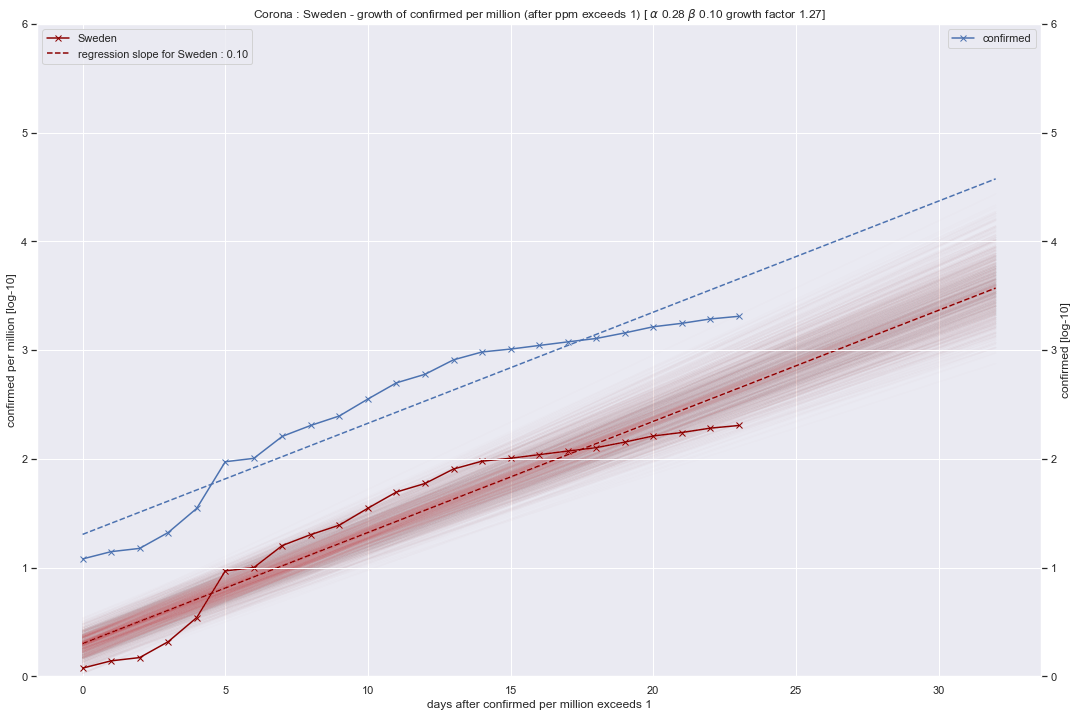

In [215]:
plt.figure(figsize=(18,12))

ax = plt.gca()
ax2 = plt.twinx()

ax.plot(np.log10(country_a['confirmed_per_M']),'x-',label=A,c='darkred')

ax2.plot(np.log10(country_a['confirmed']),'x-',color='b',label='confirmed')
ax2.legend(loc='upper right')
ax2.set_ylabel('confirmed [log-10]')
ax2.set_ylim([0,6])

#plt.plot(np.log10(country_b['confirmed_per_M']),'x-',label=B,c='orange')
#plt.plot(np.log10(country_c['confirmed_per_M']),'x-',label=C,c='yellow')
#plt.plot(np.log10(country_d['confirmed_per_M']),'x-',label=D,c='magenta')



a_slope,a_intercept = slope_overall(country_a,'confirmed_per_M')
a_conf_slope,a_conf_intercept = slope_overall(country_a,'confirmed')

#b_slope,b_intercept = slope_overall(country_b)
#c_slope,c_intercept = slope_overall(country_c)
#d_slope,d_intercept = slope_overall(country_d)


def plot_reg(ax,slope,intercept,label,color):
    ax.plot(X,[X[i] * slope + intercept for i in range(len(X))],ls='dashed',
             color=color,label='regression slope for ' + label + ' : {:.2f}'.format(slope))

plot_reg(ax,a_slope,a_intercept,A,'darkred')
plot_reg(ax2,a_conf_slope,a_conf_intercept,'A','b')

#plot_reg(b_slope,b_intercept,B,'orange')
#plot_reg(c_slope,c_intercept,C,'yellow')
#plot_reg(d_slope,d_intercept,D,'magenta')

ax.plot(X,lines,alpha=0.01,color='r')

title = r'Corona : {} - growth of confirmed per million (after ppm exceeds 1) [ $\alpha$ {:.2f} $\beta$ {:.2f} growth factor {:.2f}]'.format(
    A,alpha_mean,beta_mean,np.power(10,beta_mean))
plt.title(title)
ax.set_xlabel('days after confirmed per million exceeds 1')
ax.set_ylabel('confirmed per million [log-10]')
ax.set_ylim([0,6])
ax.legend(loc='upper left')

plt.savefig('corona_ppm_consolidated_' + A + '.jpg',format='jpg')
